In [1]:
# Initial Imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [2]:
#df = pd.read_csv(
   # Path("WEOApr2021all.csv"), parse_dates=True
#)

#df = pd.read_csv(
    #Path("GDP.csv"),
    #index_col="DATE",
    #infer_datetime_format=True,
   # parse_dates=True,
#)
#df.tail()
#set date as index 
#create lagged column for next quarters gdp


df = pd.read_csv(
    Path("WEOApr2021all.csv")
)

df = df[(df["Subject Descriptor"]=="Gross domestic product, current prices") & (df["Units"]=="U.S. dollars")]
df.drop(columns=["Subject Descriptor", "Units", "Scale", "Estimates Start After"], inplace=True)
df = df.T
df.columns = df.loc["Country"]
df = df.drop("Country", axis=0)
df.head()

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
WEO Country Code,512,914,612,614,311,213,911,314,193,122,...,111,298,927,846,299,582,487,474,754,698
ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,ABW,AUS,AUT,...,USA,URY,UZB,VUT,VEN,VNM,WBG,YEM,ZMB,ZWE
WEO Subject Code,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,...,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD
Subject Notes,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...
Country/Series-specific Notes,"See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...",...,"See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren..."


In [3]:
US_df = df[['United States']]

US_gdp = US_df.drop(labels=["WEO Country Code", "ISO", "WEO Subject Code", "Subject Notes", "Country/Series-specific Notes"], axis=0)

US_gdp.rename(columns = {'Country':'Year'}, inplace = True)

#df = df.replace(",","", regex=True)
#df = df.astype("float")
#df


US_gdp = US_gdp.replace(",","", regex=True)
US_gdp = US_gdp.astype("float")
US_gdp

Country,United States
1980,2857.33
1981,3207.03
1982,3343.80
1983,3634.03
1984,4037.65
1985,4339.00
1986,4579.63
1987,4855.25
1988,5236.43
1989,5641.60


In [4]:
def window_data(US_gdp, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(US_gdp) - window):
        features = US_gdp.iloc[i : (i + window), feature_col_number]
        target = US_gdp.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [5]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 20

feature_column = 0
target_column = 0
X, y = window_data(US_gdp, window_size, feature_column, target_column)
print (f"X sample values:\n{X} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 2857.33  3207.03  3343.8   3634.03  4037.65  4339.    4579.63  4855.25
   5236.43  5641.6   5963.13  6158.13  6520.33  6858.55  7287.25  7639.75
   8073.13  8577.55  9062.83  9630.7 ]
 [ 3207.03  3343.8   3634.03  4037.65  4339.    4579.63  4855.25  5236.43
   5641.6   5963.13  6158.13  6520.33  6858.55  7287.25  7639.75  8073.13
   8577.55  9062.83  9630.7  10252.35]
 [ 3343.8   3634.03  4037.65  4339.    4579.63  4855.25  5236.43  5641.6
   5963.13  6158.13  6520.33  6858.55  7287.25  7639.75  8073.13  8577.55
   9062.83  9630.7  10252.35 10581.83]
 [ 3634.03  4037.65  4339.    4579.63  4855.25  5236.43  5641.6   5963.13
   6158.13  6520.33  6858.55  7287.25  7639.75  8073.13  8577.55  9062.83
   9630.7  10252.35 10581.83 10936.45]
 [ 4037.65  4339.    4579.63  4855.25  5236.43  5641.6   5963.13  6158.13
   6520.33  6858.55  7287.25  7639.75  8073.13  8577.55  9062.83  9630.7
  10252.35 10581.83 10936.45 11458.25]
 [ 4339.    4579.63  4855.25  5236.43  5641.6   59

In [6]:
type(X)



#XS = float(X)
#yS = float(y)


numpy.ndarray

In [7]:
# Use 90% of the data for training and the remainder for testing
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split - 20:]
y_train = y[: split]
y_test = y[split - 20:]

In [8]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.03191488]
  [0.0121629 ]
  [0.02552812]
  [0.03643174]
  [0.02750949]
  [0.02147792]
  [0.02372472]
  [0.03195251]
  [0.03296517]
  [0.02552494]
  [0.01525586]
  [0.02706045]
  [0.02400162]
  [0.02941402]
  [0.02491874]
  [0.02882375]
  [0.03166365]
  [0.0297443 ]
  [0.03394871]
  [0.03637735]]

 [[0.04439701]
  [0.03797294]
  [0.06102983]
  [0.06363234]
  [0.04947601]
  [0.04607894]
  [0.05653579]
  [0.06591598]
  [0.05912528]
  [0.04100518]
  [0.04359265]
  [0.05232931]
  [0.05442411]
  [0.0535998 ]
  [0.05555501]
  [0.0623723 ]
  [0.06212584]
  [0.06455079]
  [0.07111254]
  [0.05565767]]

 [[0.07088444]
  [0.0738667 ]
  [0.08753605]
  [0.0853522 ]
  [0.074636

In [10]:
y_train

array([[0.        ],
       [0.01892823],
       [0.03930073],
       [0.06927752],
       [0.11267895],
       [0.15995358],
       [0.20464703],
       [0.24125801],
       [0.25624928],
       [0.24108854],
       [0.27229014],
       [0.30391858],
       [0.34151596],
       [0.37528322],
       [0.41793609],
       [0.45878335],
       [0.48789841],
       [0.53373567],
       [0.5951427 ],
       [0.64232829],
       [0.6135763 ],
       [0.71368201],
       [0.78999874],
       [0.84106556]])

In [11]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [122]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.4

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))


model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer


model.add(Dense(1))

In [123]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics= ["accuracy"])

In [124]:
# Summarize the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 20, 5)             140       
_________________________________________________________________
dropout_21 (Dropout)         (None, 20, 5)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 20, 5)             220       
_________________________________________________________________
dropout_22 (Dropout)         (None, 20, 5)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_23 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [125]:
# Train the model
model.fit(X_train, y_train, epochs=200, shuffle=False, batch_size=10, verbose=1)

Epoch 1/200
3/3 [==============================] - 3s 11ms/step - loss: 0.1859 - accuracy: 0.0417
Epoch 2/200
3/3 [==============================] - 0s 9ms/step - loss: 0.1702 - accuracy: 0.0417
Epoch 3/200
3/3 [==============================] - 0s 9ms/step - loss: 0.1601 - accuracy: 0.0417
Epoch 4/200
3/3 [==============================] - 0s 9ms/step - loss: 0.1457 - accuracy: 0.0417
Epoch 5/200
3/3 [==============================] - 0s 9ms/step - loss: 0.1448 - accuracy: 0.0417
Epoch 6/200
3/3 [==============================] - 0s 8ms/step - loss: 0.1317 - accuracy: 0.0417
Epoch 7/200
3/3 [==============================] - 0s 9ms/step - loss: 0.1145 - accuracy: 0.0417
Epoch 8/200
3/3 [==============================] - 0s 8ms/step - loss: 0.0978 - accuracy: 0.0417
Epoch 9/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0801 - accuracy: 0.0417
Epoch 10/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0778 - accuracy: 0.0417
Epoch 11/200
3/3 [=========

In [126]:
# Evaluate the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 606ms/step - loss: 0.0071 - accuracy: 0.0435


[0.007106567732989788, 0.043478261679410934]

In [127]:
predicted = model.predict(X_test)
predicted


array([[0.15718384],
       [0.1698244 ],
       [0.18414849],
       [0.20055178],
       [0.21944118],
       [0.24101338],
       [0.2652292 ],
       [0.2921097 ],
       [0.3218078 ],
       [0.35387528],
       [0.38804796],
       [0.4238396 ],
       [0.46115953],
       [0.4989735 ],
       [0.5364923 ],
       [0.57340664],
       [0.60918033],
       [0.64282906],
       [0.6748482 ],
       [0.7051267 ],
       [0.7332491 ],
       [0.7588499 ],
       [0.7821407 ]], dtype=float32)

In [49]:
X_test

array([[[0.40680693],
        [0.41378806],
        [0.42175144],
        [0.42696802],
        [0.42532896]],

       [[0.41386468],
        [0.42184895],
        [0.42723951],
        [0.43231113],
        [0.43269679]],

       [[0.42192452],
        [0.4273361 ],
        [0.43258009],
        [0.43979507],
        [0.44250472]],

       [[0.42741095],
        [0.43267577],
        [0.44006048],
        [0.44975755],
        [0.44718999]],

       [[0.43274993],
        [0.4401549 ],
        [0.45001824],
        [0.45451665],
        [0.45846758]],

       [[0.44022808],
        [0.45011099],
        [0.45477509],
        [0.46597195],
        [0.46170308]],

       [[0.45018287],
        [0.45486703],
        [0.46622496],
        [0.46925844],
        [0.46710343]],

       [[0.45493829],
        [0.46631497],
        [0.46950989],
        [0.47474389],
        [0.4686874 ]],

       [[0.46638473],
        [0.46959935],
        [0.47499274],
        [0.47635282],
        [0.47460

In [128]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [105]:
predicted_prices.ravel().shape

(48,)

In [129]:
# Create a DataFrame of Real and Predicted values
GDP = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
GDP

,Real,Predicted
2004,12213.73,12988.417969
2005,13036.63,13208.449219
2006,13814.60,13457.786133
2007,14451.88,13743.315430
2008,14712.83,14072.118164
2009,14448.93,14447.622070
2010,14992.05,14869.141602
2011,15542.60,15337.044922
2012,16197.05,15853.994141
2013,16784.83,16412.185547


<AxesSubplot:>

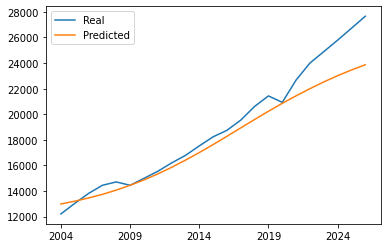

In [130]:
# Plot the real vs predicted prices as a line chart
GDP.plot()

## China LSTM GDP predictor